<a href="https://colab.research.google.com/github/averma12/Full-Stack-DL/blob/master/ULMFIT_Hindi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from fastai import *
from fastai.text import *

In [0]:
bs = 64

In [0]:
data_path = Config.data_path()
lang = 'hi'
name = f'{lang}wiki'
path = data_path/name
dest = path/'docs'
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

In [0]:
from fastai.basics import *
import re

In [0]:
## Get wiki data helper function
def get_wiki(path,lang):
    name = f'{lang}wiki'
    if (path/name).exists():
        print(f"{path/name} already exists; not downloading")
        return

    xml_fn = f"{lang}wiki-latest-pages-articles.xml"
    zip_fn = f"{xml_fn}.bz2"

    if not (path/xml_fn).exists():
        print("downloading...")
        download_url(f'https://dumps.wikimedia.org/{name}/latest/{zip_fn}', path/zip_fn)
        print("unzipping...")
        bunzip(path/zip_fn)

    with working_directory(path):
        if not (path/'wikiextractor').exists(): os.system('git clone https://github.com/attardi/wikiextractor.git')
        print("extracting...")
        os.system("python wikiextractor/WikiExtractor.py --processes 4 --no_templates " +
            f"--min_text_length 1800 --filter_disambig_pages --log_file log -b 100G -q {xml_fn}")
    shutil.move(str(path/'text/AA/wiki_00'), str(path/name))
    shutil.rmtree(path/'text')


def split_wiki(path,lang):
    dest = path/'docs'
    name = f'{lang}wiki'
    if dest.exists():
        print(f"{dest} already exists; not splitting")
        return dest

    dest.mkdir(exist_ok=True, parents=True)
    title_re = re.compile(rf'<doc id="\d+" url="https://{lang}.wikipedia.org/wiki\?curid=\d+" title="([^"]+)">')
    lines = (path/name).open()
    f=None

    for i,l in enumerate(lines):
        if i%100000 == 0: print(i)
        if l.startswith('<doc id="'):
            title = title_re.findall(l)[0].replace('/','_')
            if len(title)>150: continue
            if f: f.close()
            f = (dest/f'{title}.txt').open('w')
        else: f.write(l)
    f.close()
    return dest

In [6]:
!pip install sentencepiece

     |████████████████████████████████| 1.0MB 4.6MB/s 


In [0]:
import sentencepiece as spm
sp = spm.SentencePieceProcessor()

In [8]:
lang

'hi'

In [0]:
model_path = f'/content/hindi_lm_large.model'

In [10]:
model_path

'/content/hindi_lm_large.model'

In [11]:
sp.Load(str(model_path))

True

In [0]:
from indicnlp.tokenize import indic_tokenize

In [0]:
indic_string='सुनो, कुछ आवाज़ आ रही है। फोन?'

In [0]:
indic_tokenize.trivial_tokenize(indic_string)

['सुनो', ',', 'कुछ', 'आवाज़', 'आ', 'रही', 'है', '।', 'फोन', '?']

In [0]:
class HindiTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(model_path)
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [0]:
tokenizer = Tokenizer(tok_func=HindiTokenizer,lang="Hi")

In [0]:
sp = spm.SentencePieceProcessor()
sp.Load(str("hindi_lm_large.model"))
itos = [sp.IdToPiece(int(i)) for i in range(30000)]

In [0]:
hindi_vocab = Vocab(itos)

In [15]:
get_wiki(path,lang)

downloading...


unzipping...
extracting...


In [0]:
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

In [16]:
dest = split_wiki(path,lang)

0
100000
200000
300000
400000
500000
600000
700000


In [0]:
??TextList

In [0]:
processor = [TokenizeProcessor(tokenizer=tokenizer, chunksize=10000, mark_fields=False),
            NumericalizeProcessor(vocab=hindi_vocab, max_vocab=30000, min_freq=1)]

In [0]:
?? SPProcessor

In [32]:
data = (TextList.from_folder(dest,processor=[OpenFileProcessor(), SPProcessor(vocab_sz=30000)])
        .split_by_rand_pct(0.1, seed=42)
        .label_for_lm()
        .databunch(tokenizer=tokenizer,vocab=hindi_vocab,bs=bs, num_workers=1))

FileNotFoundError: ignored

In [34]:
dest

PosixPath('/root/.fastai/data/hiwiki/docs')

In [40]:
f = []
file_list = []
for (dirpath, dirnames, filenames) in os.walk(dest):
    print(len(filenames))
    print(dest)
    file_list.extend(filenames)
    for file in filenames:
        with open(f"{dest}/{file}","r") as read_file:
            read = read_file.read()
            f.append(read)
    
    break

17963
/root/.fastai/data/hiwiki/docs


In [41]:
len(f)

17963

In [53]:
f[0]

"प्रोकैरियोटिक त्रान्स्लेशनप्रोकेरियोट्स वह जन्तु होते हैं जिन में अलग नाभिक और झिल्ली बाध्या ओरगेनेल्ले नहीं होते हैं। प्रोकेरियोटिक त्रन्स्लेशन मैं तीन विभाजन पाये जाते हैं। १- इनीशीएशन (दीक्षा)२-एलोंगेशन३- समाप्तिप्रोकेरियोतटिक त्रन्सलेशन के शुरुवात के लिये दो घटकों की आवश्यकता होती हैं और वह हैं- दो राइबोसोमल सब युनिट (५०एस और ३० एस सब युनिट),परिपक्क एम आरएनए जिसका त्रन्सलेशन होने जा रहा हैं, एन- फोरमाइलमिथियोनिन से प्रभारित टी-आरएनए, ऊर्जा के एक स्रोत के रूप में ग्वानोसिन त्रिकोणीय फॉस्फेट (जिटीपि), प्रोकेरियोटिक बढ़ाव कारक ईएफ-P और तीन प्रोकेरियोटिक इनीशीएशन कारक आइ एफ-१, आइ एफ-२, आइ एफ-३ जो जटिल दीक्षा का विधान सभा में मदद करता हैं। तंत्र में बदलाव प्रत्याशित हो सकते हैं।ए साइट, पी साइट, इ साईट : : राइबोसोम तीन सक्रिय स्थलों की है। ए साइट ( अमीनोएसिल टी-आरएनए को छोड़कर जो पी साइट में प्रवेश करत हैं)। पी साइट वो जगह हैं जहाँ पेप्टिडाइल टी-आरएनए, का गठन राइबोसोम मैं होता हैं, और यह बढ़ रही पेप्टाइड श्रृंखला के लिए अपनी अमीनो एसिड देने है के बाद अब अनचारज्ड टी-आरएनए के बाहर निकलने 

In [0]:
train_df = pd.DataFrame({"articles":np.array(f,dtype=np.object)})

In [55]:
train_df.head()

,articles
0,प्रोकैरियोटिक त्रान्स्लेशनप्रोकेरियोट्स वह जन्...
1,भू-चुबंकी प्रेरक दिक्सूचकभू-चुबंकी प्रेरक दिक्...
2,लोकगीत (हिन्दी)वर्तमान हिंदीभाषी क्षेत्र प्राच...
3,"लाला हरदयाललाला हरदयाल (१४ अक्टूबर १८८४, दिल्ल..."
4,बराकर नदीबराकर नदी () () पुर्वी भारत में दामोद...


In [0]:
f = [name.replace("\n", " ") for name in f]

In [49]:
dest.ls()[:5]

[PosixPath('/root/.fastai/data/hiwiki/docs/प्रोकैरियोटिक त्रान्स्लेशन.txt'),
 PosixPath('/root/.fastai/data/hiwiki/docs/भू-चुबंकी प्रेरक दिक्सूचक.txt'),
 PosixPath('/root/.fastai/data/hiwiki/docs/लोकगीत (हिन्दी).txt'),
 PosixPath('/root/.fastai/data/hiwiki/docs/लाला हरदयाल.txt'),
 PosixPath('/root/.fastai/data/hiwiki/docs/बराकर नदी.txt')]

In [0]:
from sklearn.model_selection import train_test_split
X_train, y_train = train_test_split(train_df, test_size=0.2)

In [59]:
len(X_train),len(y_train)

(14370, 3593)

In [62]:
X_train.head()

,articles
13927,"संजीवसंजीव (6 जुलाई, 1947 से वर्तमान) हिन्दी स..."
10657,उत्तर-प्रत्यक्षवाद (अंतरराष्ट्रीय संबंध)अंतररा...
13549,सीएमएस प्रयोगसीएमएस या कॉम्पैक्ट म्यूऑन सोलेनो...
12007,छिद्रहीन योनिच्छदछिद्रहीन योनिच्छद एक जन्मजात ...
2929,उर्मिला सिंहउर्मिला सिंह (जन्म: 6 अगस्त 1946) ...


In [61]:
data_lm = TextLMDataBunch.from_df('',X_train.reset_index(),y_train.reset_index(), tokenizer=tokenizer, vocab=hindi_vocab,bs=64)

In [63]:
data_lm.show_batch()

idx,text
0,"▁जुलाई , ▁1947 ▁ई <unk> ▁को ▁उत्तर ▁प्रदेश ▁के ▁सुल्तानपुर ▁जिले ▁के ▁गाँव ▁बाँ गर ▁कला ँ ▁में ▁हुआ ▁था । ▁इनकी ▁उच्च ▁शिक्षा ▁विज्ञान ▁विषयों ▁को ▁लेकर ▁हुई । ▁बी <unk> एस - सी <unk> , ▁ए <unk> आई <unk> सी <unk> ▁की ▁डिग्री ▁लेकर ▁इन्होंने ▁सन् ▁1965 ▁से ▁2003 ▁ई <unk> ▁तक ▁इंडियन ▁आयरन ▁एंड ▁स्टील ▁कंपनी , ▁कुल ्टी ▁में ▁के मिस्ट ▁इं चार्ज ▁के ▁रूप ▁में"
1,"ज् द्र ेव "" ', ▁' "" स वा के विच "" ' ▁ <unk> कु त्ते ▁का ▁पि ल्ला ) , ▁' "" प् ल्यू श ्किन "" ', ▁चि चि को व "" ' ▁आदि ▁के ▁रूप ▁में ▁भी ▁गो गोल ▁ने ▁अपनी ▁रचनात्मक ▁सामर्थ्य ▁का ▁परिचय ▁दिया ▁है । ▁अपनी ▁रचनाओं ▁के ▁माध्यम ▁से ▁गो गोल ▁ने ▁रूसी ▁साहित्य ▁में ▁आलोचनात्मक ▁यथार्थवाद "" ' ▁की ▁नींव ▁डाली"
2,"▁है , ▁और ▁सबसे ▁अच्छा ▁राज्य ▁प्रदर्शन ▁पुरस्कार , ▁भारत ▁सरकार ▁द्वारा ▁संकलित ▁सांख्यिकीय ▁आंकड़ों ▁के ▁आधार ▁पर ▁जीता ▁है । ▁वर्ष ▁2012 ▁में ▁राज्य ▁भारत ▁के ▁लिए ▁समग्र ▁प्रेषण ▁जो ▁66 . 13 ▁$ ▁अरब ▁ <unk> 45 47 4 29 45 ▁x x re p ▁4 ▁0 ▁ .00 ▁भारतीय ▁रुपए ) ▁पर ▁खड़ा ▁था , ▁केरल , ▁तमिलनाडु ▁और ▁उत्तर ▁प्रदेश ▁के ▁नीचे ▁के ▁उच्चतम ▁रिसीवर ▁में"
3,"▁किया ▁गया ▁था , ▁और ▁उन्हें ▁समाज ▁का ▁सदस्य ▁नहीं ▁माना ▁जाता ▁था । ▁इतिहासकार ▁रोम िला ▁था पर ▁के ▁अनुसार ▁ , ▁भारतीय ▁समाज ▁में ▁दासों ▁और ▁अन्य ▁लोगों ▁के ▁बीच ▁तीव्र ▁अंतर ▁का ▁अभाव ▁ <unk> ▁ग्रीक ▁समाज ▁के ▁विपरीत ▁) ▁ने ▁मेगस्थनीज ़ ▁को ▁भ्रमित ▁किया ▁हो ▁सकता ▁है : ▁भारतीयों ▁ने ▁उत्पादन ▁के ▁साधन ▁के ▁रूप ▁में ▁बड़े ▁पैमाने ▁पर ▁गुलामी ▁का ▁उपयोग ▁नहीं ▁किया ,"
4,"▁किया ▁जा ▁सकता ▁है । ▁पूर्व ▁और ▁पश्चिम ▁दोनों ▁में ▁सदियों ▁तक ▁धार्मिक ▁संस्थाएँ , ▁सरकार , ▁विश्वविद्यालय ▁तथा ▁अन्य ▁शक्ति शाल िनी ▁संस्थाएँ ▁अपने ▁ही ▁विचारों ▁और ▁सूचनाओं ▁के ▁प्रसार ▁में ▁मुद्रण ▁का ▁उपयोग ▁करती ▁रहीं ▁और ▁उन्होंने ▁ज्ञान ▁के ▁प्रसार ▁में ▁उसके ▁उपयोग ▁का ▁निरंतर ▁विरोध ▁किया । ▁बाद ▁में , ▁आखिरकार ▁आत्मिक ▁एवं ▁बौद्धिक ▁विकास ▁संबंधी ▁अथवा ▁धार्मिक ▁एवं ▁वैज्ञानिक ▁साहित्य ▁के ▁प्रकाशन ▁में ▁मुद्रण ▁का ▁शत"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM,drop_mult=1.0,wd=0.1, pretrained=False)

In [82]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


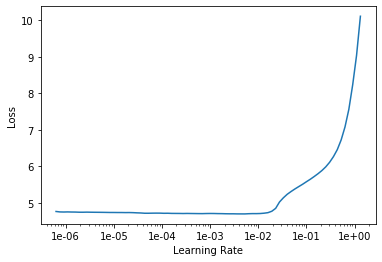

In [83]:
learn.recorder.plot()

In [75]:
learn.fit_one_cycle(10,1e-3,moms=(0.8,0.7),callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='model')])

epoch,train_loss,valid_loss,accuracy,time
0,7.482059,7.509008,0.035876,17:17
1,7.360994,7.356290,0.061068,17:18
2,5.953949,5.942132,0.160586,17:22
3,5.366795,5.345860,0.199632,17:24
4,5.039505,5.003708,0.228163,17:20
5,4.856654,4.831053,0.242256,17:30
6,4.828030,4.738739,0.250630,17:32
7,4.721404,4.669031,0.256698,17:33
8,4.705255,4.635407,0.259839,17:32
9,4.673303,4.625557,0.260855,17:33


Better model found at epoch 0 with accuracy value: 0.0358758270740509.
Better model found at epoch 1 with accuracy value: 0.061067841947078705.
Better model found at epoch 2 with accuracy value: 0.16058558225631714.
Better model found at epoch 3 with accuracy value: 0.1996317058801651.
Better model found at epoch 4 with accuracy value: 0.2281630039215088.
Better model found at epoch 5 with accuracy value: 0.2422555536031723.
Better model found at epoch 6 with accuracy value: 0.25062981247901917.
Better model found at epoch 7 with accuracy value: 0.25669756531715393.
Better model found at epoch 8 with accuracy value: 0.25983932614326477.
Better model found at epoch 9 with accuracy value: 0.26085469126701355.


In [81]:
learn.fit_one_cycle(1,7e-4,moms=(0.9,0.8))

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: ignored

In [79]:
learn.predict("नमकीन कैसे बनाते हैं",n_words=20)

'नमकीन कैसे बनाते हैं ▁कि ▁मुझे ▁लगता ▁है ▁आज ▁भी ▁हम ▁प्यार ▁करता ▁रहा ▁हैं ▁यानि ▁दाम ▁टूट ती ▁विशेषज्ञों ▁या ▁तो ओ ▁मे'